In [1]:
# data manipulation
import numpy as np
import pandas as pd

# graphs
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# data parsers
from ast import literal_eval
from datetime import datetime, timezone

# API
import requests
from tqdm import tqdm

In [2]:
df = pd.read_csv("./NCSC_advisories.csv")
df1 = df.copy()

In [3]:
df.head()

,Unnamed: 0,Titel,Advisory ID,NCSC ID,Versie,Uitgiftedatum,CVE-ID,NCSC inschaling,Kans,Schade,Schadeomschrijving,Toepassingen,Versies,Platformen,Beschrijving,Mogelijke oplossingen
0,0,0-day SMB kwetsbaarheid in Windows Vista en Se...,32000,GOVCERT.NL-2009-261,1.01,2009-09-15T14:15:21+02:00,['CVE-2009-3103'],High/High,High,High,Uitvoeren van willekeurige code [Root/Administ...,[],[],"['Windows Server 2008', 'Windows Vista']",Er bevindt zich een 0-day kwetsbaarheid in de ...,Microsoft heeft nog geen update uit kunnen bre...
1,1,Kwetsbaarheden verholpen in Apple iOS en iPadOS,250093916,NCSC-2022-0776,1.00,2022-12-15T13:17:12+01:00,"['CVE-2022-32943', 'CVE-2022-40303', 'CVE-2022...",Medium/High,Medium,High,Lekken van gevoelige informatie [Gebruikersdat...,[],"['15.7.2', '16.1.2', '16.2']","['Apple iOS', 'Apple iPadOS']",Apple heeft kwetsbaarheden verholpen in iOS en...,Apple heeft updates uitgebracht om de kwetsbaa...
2,2,Kwetsbaarheid verholpen in Cacti,250094516,NCSC-2022-0759,1.01,2023-01-16T13:06:33+01:00,['CVE-2022-46169'],High/Medium,High,Medium,Lekken van gevoelige informatie [Systeemdata]\...,['Cacti'],['1.2.22'],[],Er zijn kwetsbaarheden verholpen in Cacti.\nDe...,Cacti heeft updates uitgebracht om de kwetsbaa...
3,3,IBM WebSphere MQ 7 Multiple Vulnerabilities,32001,GOVCERT.NL-2009-269,1.00,2009-09-15T16:39:38+02:00,['CVE-2009-3106'],Medium/High,Medium,High,Denial of service [Infrastructuur dienst],['IBM WebSphere MQ'],['7'],"['HP-UX', 'IBM AIX', 'IBM ZOS', 'Linux', 'Micr...",In IBM WebSphere MQ 7 is een aantal verschille...,IBM heeft een aantal security bulletins uitgeg...
4,4,Kwetsbaarheden verholpen in Apple macOS,250093926,NCSC-2022-0777,1.00,2022-12-15T13:17:27+01:00,"['CVE-2022-24836', 'CVE-2022-29181', 'CVE-2022...",Medium/High,Medium,High,Lekken van gevoelige informatie [Gebruikersdat...,[],"['11.7.2', '12.6.2', '13.1']",['Apple macOS'],Apple heeft kwetsbaarheden verholpen in macOS ...,Apple heeft updates beschikbaar gesteld voor m...


In [4]:
df.dtypes

Unnamed: 0                 int64
Titel                     object
Advisory ID                int64
NCSC ID                   object
Versie                   float64
Uitgiftedatum             object
CVE-ID                    object
NCSC inschaling           object
Kans                      object
Schade                    object
Schadeomschrijving        object
Toepassingen              object
Versies                   object
Platformen                object
Beschrijving              object
Mogelijke oplossingen     object
dtype: object

In [5]:
def parse_time(t):
    return datetime.strptime(t.replace(':', ''), '%Y-%m-%dT%H%M%S%z')

# clean data
def clean_NCSC(df):
    
    # delete columns with descriptions
    df = df[['Advisory ID', 'NCSC ID', 'Versie',
       'Uitgiftedatum', 'CVE-ID', 'NCSC inschaling', 'Kans', 'Schade',
       'Schadeomschrijving', 'Toepassingen', 'Versies', 'Platformen']]
        
    # parse timestamps
    df = df.assign(Uitgiftedatum=df["Uitgiftedatum"].apply(parse_time))
    
    # parse lists
    df = df.assign(**{"CVE-ID": df["CVE-ID"].apply(literal_eval)})
    df = df.assign(Versies=df["Versies"].apply(literal_eval))
    df = df.assign(Platformen=df["Platformen"].apply(literal_eval))
    df = df.assign(Toepassingen=df["Toepassingen"].apply(literal_eval))
    
    return df

In [6]:
df = clean_NCSC(df)
df.head()

,Advisory ID,NCSC ID,Versie,Uitgiftedatum,CVE-ID,NCSC inschaling,Kans,Schade,Schadeomschrijving,Toepassingen,Versies,Platformen
0,32000,GOVCERT.NL-2009-261,1.01,2009-09-15 14:15:21+02:00,[CVE-2009-3103],High/High,High,High,Uitvoeren van willekeurige code [Root/Administ...,[],[],"[Windows Server 2008, Windows Vista]"
1,250093916,NCSC-2022-0776,1.00,2022-12-15 13:17:12+01:00,"[CVE-2022-32943, CVE-2022-40303, CVE-2022-4030...",Medium/High,Medium,High,Lekken van gevoelige informatie [Gebruikersdat...,[],"[15.7.2, 16.1.2, 16.2]","[Apple iOS, Apple iPadOS]"
2,250094516,NCSC-2022-0759,1.01,2023-01-16 13:06:33+01:00,[CVE-2022-46169],High/Medium,High,Medium,Lekken van gevoelige informatie [Systeemdata]\...,[Cacti],[1.2.22],[]
3,32001,GOVCERT.NL-2009-269,1.00,2009-09-15 16:39:38+02:00,[CVE-2009-3106],Medium/High,Medium,High,Denial of service [Infrastructuur dienst],[IBM WebSphere MQ],[7],"[HP-UX, IBM AIX, IBM ZOS, Linux, Microsoft Win..."
4,250093926,NCSC-2022-0777,1.00,2022-12-15 13:17:27+01:00,"[CVE-2022-24836, CVE-2022-29181, CVE-2022-3294...",Medium/High,Medium,High,Lekken van gevoelige informatie [Gebruikersdat...,[],"[11.7.2, 12.6.2, 13.1]",[Apple macOS]


In [7]:
df.dtypes

Advisory ID             int64
NCSC ID                object
Versie                float64
Uitgiftedatum          object
CVE-ID                 object
NCSC inschaling        object
Kans                   object
Schade                 object
Schadeomschrijving     object
Toepassingen           object
Versies                object
Platformen             object
dtype: object

In [8]:
# get dict CVE-ID -> time
def cve_time_dict(df):
    
    xs = dict()
    df = df[["Uitgiftedatum", "CVE-ID"]]
    for idx, row in df.iterrows():
        for cve in row["CVE-ID"]:
            timestamp = row["Uitgiftedatum"]
            if cve in xs.keys():
                xs[cve].append(timestamp)
                xs[cve].sort()
            else:
                xs[cve] = [timestamp]
    return xs

In [9]:
cve_time = cve_time_dict(df)
cve_time['CVE-2022-40304']

[datetime.datetime(2022, 11, 7, 14, 33, 34, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 datetime.datetime(2022, 11, 10, 10, 22, 18, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 datetime.datetime(2022, 12, 12, 12, 56, 50, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 datetime.datetime(2022, 12, 15, 13, 17, 12, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 datetime.datetime(2022, 12, 15, 13, 17, 27, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 datetime.datetime(2022, 12, 20, 15, 25, 52, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600)))]

# Metric 1 - Reaction time NCSC

In [10]:
# group data for months and sum
def transform_datetime_to_date(t):
    return datetime(t.date().year, t.date().month, 1)

d = {'Uitgiftedatum': df['Uitgiftedatum'].apply(transform_datetime_to_date)}

df_temp = pd.DataFrame(data=d)

df_temp["count"] = df_temp.groupby(['Uitgiftedatum']).transform('size')
df_temp = df_temp.sort_values(by=['Uitgiftedatum'])
df_temp

,Uitgiftedatum,count
8560,2002-05-01,12
4202,2002-05-01,12
4201,2002-05-01,12
4200,2002-05-01,12
8548,2002-05-01,12
...,...,...
32,2023-01-01,39
31,2023-01-01,39
26,2023-01-01,39
52,2023-01-01,39


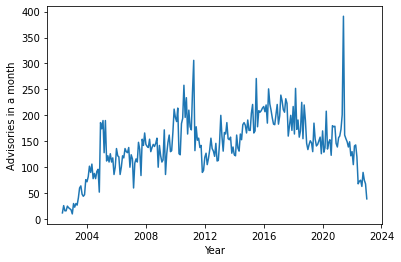

In [11]:
# plot timeline advisories
fig, ax = plt.subplots()
ax.plot(df_temp['Uitgiftedatum'], df_temp['count'])
plt.xlabel("Year")
plt.ylabel("Advisories in a month")
plt.show()

In [12]:
cve_first_seen = dict()
for k in cve_time.keys():
    
    d = transform_datetime_to_date(cve_time[k][0])
    if d in cve_first_seen:
        cve_first_seen[d] += 1
    else:
        cve_first_seen[d] = 1
cve_first_seen = dict(sorted(cve_first_seen.items()))

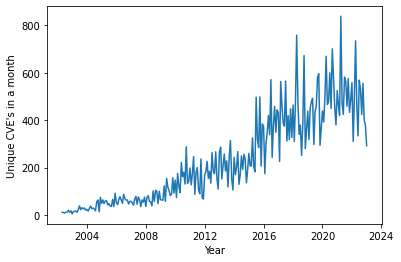

In [13]:
# plot timeline individual CVE's in advisories
fig, ax = plt.subplots()
ax.plot(cve_first_seen.keys(), cve_first_seen.values())
plt.xlabel("Year")
plt.ylabel("Unique CVE's in a month")
plt.show()

In [15]:
cve_timedelta = dict()
Full_CVE_pubs = []
api_url = "https://services.nvd.nist.gov/rest/json/cves/2.0"

# request publication time
response = requests.get(api_url)
json_response = response.json()
total = json_response["totalResults"]
print(f"total: {total}, advised cve's: {len(cve_time.keys())}")

with tqdm(total=total) as t:
    
    for i in range((total // 2000) + 1):
        
        response = requests.get(api_url + f"/?resultsPerPage=2000&startIndex={2000 * i}")
        json_response = response.json()
        
        for k in json_response["vulnerabilities"]:

            t.update(1)
                
            k_id = k["cve"]["id"]
            
            if response.status_code == 200:
                pub = datetime.fromisoformat(k["cve"]["published"])
                pub = datetime.combine(pub.date(), pub.time(), timezone.utc)
                Full_CVE_pubs.append(pub)

                base2, base3, unknown2, unknown3 = 0, 0, 0, 0
                if "cvssMetricV2" in k["cve"]["metrics"]:
                    base2 = k["cve"]["metrics"]["cvssMetricV2"][0]["cvssData"]["baseScore"]
                else:
                    unknown2 = 1
                if "cvssMetricV30" in k["cve"]["metrics"]:
                    base3 = k["cve"]["metrics"]["cvssMetricV30"][0]["cvssData"]["baseScore"]
                else:
                    unknown3 = 1
            else:
                print("skipped")
                continue

            delta = "unknown"
            if k_id in cve_time.keys():
                advisory = cve_time[k_id][0]
                delta = (advisory - pub).days # #days

            if delta in cve_timedelta:
                cve_timedelta[delta][0] += 1
                
                cve_timedelta[delta][1] += base2
                cve_timedelta[delta][2] += base3
                
                cve_timedelta[delta][3] += unknown2
                cve_timedelta[delta][4] += unknown3
            else:
                cve_timedelta[delta] = [1, base2, base3, unknown2, unknown3]

print(f"unknown: {cve_timedelta['unknown']}")
del cve_timedelta["unknown"]

cve_timedelta = dict(sorted(cve_timedelta.items()))
idx = list(cve_timedelta.keys()).index(0)
a = np.array(list(cve_timedelta.values()))

print(f"avg cvss2 late response: {np.sum(a[idx:, 1]) / (np.sum(a[idx:, 0]) - np.sum(a[idx:, 3]))}")
print(f"avg cvss2 early response: {np.sum(a[:idx, 1]) / (np.sum(a[:idx, 0]) - np.sum(a[:idx, 3]))}")

print(f"avg cvss3 late response: {np.sum(a[idx:, 2]) / (np.sum(a[idx:, 0]) - np.sum(a[idx:, 4]))}")
print(f"avg cvss3 early response: {np.sum(a[:idx, 2]) / (np.sum(a[:idx, 0]) - np.sum(a[:idx, 4]))}")

d = {'delta': cve_timedelta.keys(), 'count': a[:, 0], 'cvss2': a[:, 1] / (a[:, 0] - a[:, 3]), 'cvss3': a[:, 2] / (a[:, 0] - a[:, 4])}
df_cve_timedelta = pd.DataFrame(data=d)
df_cve_timedelta.to_csv('./timedelta.csv', index=False)

total: 227809, advised cve's: 57184


100%|████████████████████████████████████████████████████████████████████████| 227809/227809 [03:26<00:00, 1103.29it/s]

unknown: [172350, 750443.6000001415, 259205.69999994637, 42887, 135765]
avg cvss2 late response: 5.898792120269594
avg cvss2 early response: 6.262871872630825
avg cvss3 late response: 7.114831243973
avg cvss3 early response: 7.209800259824602



C:\Users\GamePC 2.0\AppData\Local\Temp\ipykernel_13148\927560975.py:71: RuntimeWarning: invalid value encountered in true_divide
  d = {'delta': cve_timedelta.keys(), 'count': a[:, 0], 'cvss2': a[:, 1] / (a[:, 0] - a[:, 3]), 'cvss3': a[:, 2] / (a[:, 0] - a[:, 4])}


In [16]:
cve_first_seen = dict()
for k in Full_CVE_pubs:
    
    d = transform_datetime_to_date(k)
    if d in cve_first_seen:
        cve_first_seen[d] += 1
    else:
        cve_first_seen[d] = 1
cve_first_seen = dict(sorted(cve_first_seen.items()))

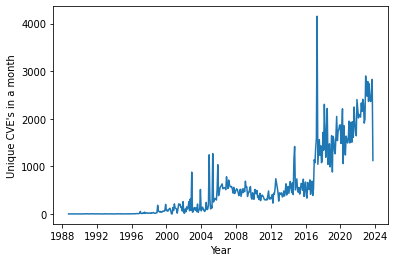

In [17]:
# plot timeline all CVE's
fig, ax = plt.subplots()
ax.plot(cve_first_seen.keys(), cve_first_seen.values())
plt.xlabel("Year")
plt.ylabel("Unique CVE's in a month")
plt.show()

In [18]:
df_cve_timedelta = pd.read_csv("./timedelta.csv")
df_cve_timedelta.head()

,delta,count,cvss2,cvss3
0,-4712,2.0,NaN,NaN
1,-3998,1.0,7.2,NaN
2,-3396,1.0,1.9,NaN
3,-3250,1.0,6.5,NaN
4,-3167,2.0,6.8,NaN


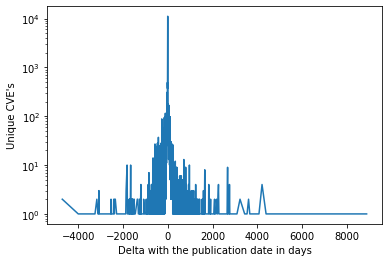

In [19]:
# plot API timedelta's
fig, ax = plt.subplots()
ax.plot(df_cve_timedelta['delta'], df_cve_timedelta['count'])
plt.xlabel("Delta with the publication date in days")
plt.ylabel("Unique CVE's")
plt.semilogy()
plt.show()

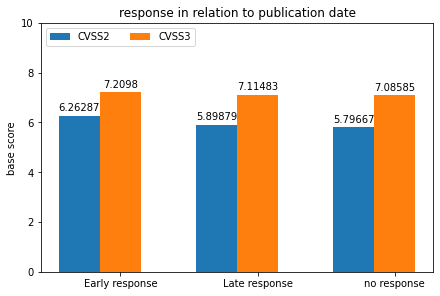

In [20]:
# plot CVSS based on timedelta's
types = ("Early response", "Late response", "no response")
means = {
    'CVSS2': (np.sum(a[:idx, 1]) / (np.sum(a[:idx, 0]) - np.sum(a[:idx, 3])), np.sum(a[idx:, 1]) / (np.sum(a[idx:, 0]) - np.sum(a[idx:, 3])), 5.79666684691),
    'CVSS3': (np.sum(a[:idx, 2]) / (np.sum(a[:idx, 0]) - np.sum(a[:idx, 4])), np.sum(a[idx:, 2]) / (np.sum(a[idx:, 0]) - np.sum(a[idx:, 4])), 7.08585101728),
}

x = np.arange(len(types))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('base score')
ax.set_title('response in relation to publication date')
ax.set_xticks(x + width, types)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 10)

plt.show()

# Metric 2 and 3 - Patching prioritisation based on damage of attacks

In [3]:
df_og = pd.read_csv("./NCSC_advisories.csv")
df_copy = df_og.copy()
df1 = df_copy[:]

In [4]:
df1.head()

,Unnamed: 0,Titel,Advisory ID,NCSC ID,Versie,Uitgiftedatum,CVE-ID,NCSC inschaling,Kans,Schade,Schadeomschrijving,Toepassingen,Versies,Platformen,Beschrijving,Mogelijke oplossingen
0,0,0-day SMB kwetsbaarheid in Windows Vista en Se...,32000,GOVCERT.NL-2009-261,1.01,2009-09-15T14:15:21+02:00,['CVE-2009-3103'],High/High,High,High,Uitvoeren van willekeurige code [Root/Administ...,[],[],"['Windows Server 2008', 'Windows Vista']",Er bevindt zich een 0-day kwetsbaarheid in de ...,Microsoft heeft nog geen update uit kunnen bre...
1,1,Kwetsbaarheden verholpen in Apple iOS en iPadOS,250093916,NCSC-2022-0776,1.00,2022-12-15T13:17:12+01:00,"['CVE-2022-32943', 'CVE-2022-40303', 'CVE-2022...",Medium/High,Medium,High,Lekken van gevoelige informatie [Gebruikersdat...,[],"['15.7.2', '16.1.2', '16.2']","['Apple iOS', 'Apple iPadOS']",Apple heeft kwetsbaarheden verholpen in iOS en...,Apple heeft updates uitgebracht om de kwetsbaa...
2,2,Kwetsbaarheid verholpen in Cacti,250094516,NCSC-2022-0759,1.01,2023-01-16T13:06:33+01:00,['CVE-2022-46169'],High/Medium,High,Medium,Lekken van gevoelige informatie [Systeemdata]\...,['Cacti'],['1.2.22'],[],Er zijn kwetsbaarheden verholpen in Cacti.\nDe...,Cacti heeft updates uitgebracht om de kwetsbaa...
3,3,IBM WebSphere MQ 7 Multiple Vulnerabilities,32001,GOVCERT.NL-2009-269,1.00,2009-09-15T16:39:38+02:00,['CVE-2009-3106'],Medium/High,Medium,High,Denial of service [Infrastructuur dienst],['IBM WebSphere MQ'],['7'],"['HP-UX', 'IBM AIX', 'IBM ZOS', 'Linux', 'Micr...",In IBM WebSphere MQ 7 is een aantal verschille...,IBM heeft een aantal security bulletins uitgeg...
4,4,Kwetsbaarheden verholpen in Apple macOS,250093926,NCSC-2022-0777,1.00,2022-12-15T13:17:27+01:00,"['CVE-2022-24836', 'CVE-2022-29181', 'CVE-2022...",Medium/High,Medium,High,Lekken van gevoelige informatie [Gebruikersdat...,[],"['11.7.2', '12.6.2', '13.1']",['Apple macOS'],Apple heeft kwetsbaarheden verholpen in macOS ...,Apple heeft updates beschikbaar gesteld voor m...


In [5]:
# Factorise each unique attack to a integer value, factorise function ensures that same attacks are assigned the 
# same correct integer category value
df1['Categorical_Schadeomschrijving'] = pd.factorize(df1['Schadeomschrijving'])[0]
df1['Categorical_Schadeomschrijving']

C:\Users\Varun22\AppData\Local\Temp\ipykernel_12052\684534655.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Categorical_Schadeomschrijving'] = pd.factorize(df1['Schadeomschrijving'])[0]


0         0
1         1
2         2
3         3
4         1
         ..
35679    95
35680     2
35681    47
35682     6
35683    -1
Name: Categorical_Schadeomschrijving, Length: 35684, dtype: int64

In [6]:
df1.head()

,Unnamed: 0,Titel,Advisory ID,NCSC ID,Versie,Uitgiftedatum,CVE-ID,NCSC inschaling,Kans,Schade,Schadeomschrijving,Toepassingen,Versies,Platformen,Beschrijving,Mogelijke oplossingen,Categorical_Schadeomschrijving
0,0,0-day SMB kwetsbaarheid in Windows Vista en Se...,32000,GOVCERT.NL-2009-261,1.01,2009-09-15T14:15:21+02:00,['CVE-2009-3103'],High/High,High,High,Uitvoeren van willekeurige code [Root/Administ...,[],[],"['Windows Server 2008', 'Windows Vista']",Er bevindt zich een 0-day kwetsbaarheid in de ...,Microsoft heeft nog geen update uit kunnen bre...,0
1,1,Kwetsbaarheden verholpen in Apple iOS en iPadOS,250093916,NCSC-2022-0776,1.00,2022-12-15T13:17:12+01:00,"['CVE-2022-32943', 'CVE-2022-40303', 'CVE-2022...",Medium/High,Medium,High,Lekken van gevoelige informatie [Gebruikersdat...,[],"['15.7.2', '16.1.2', '16.2']","['Apple iOS', 'Apple iPadOS']",Apple heeft kwetsbaarheden verholpen in iOS en...,Apple heeft updates uitgebracht om de kwetsbaa...,1
2,2,Kwetsbaarheid verholpen in Cacti,250094516,NCSC-2022-0759,1.01,2023-01-16T13:06:33+01:00,['CVE-2022-46169'],High/Medium,High,Medium,Lekken van gevoelige informatie [Systeemdata]\...,['Cacti'],['1.2.22'],[],Er zijn kwetsbaarheden verholpen in Cacti.\nDe...,Cacti heeft updates uitgebracht om de kwetsbaa...,2
3,3,IBM WebSphere MQ 7 Multiple Vulnerabilities,32001,GOVCERT.NL-2009-269,1.00,2009-09-15T16:39:38+02:00,['CVE-2009-3106'],Medium/High,Medium,High,Denial of service [Infrastructuur dienst],['IBM WebSphere MQ'],['7'],"['HP-UX', 'IBM AIX', 'IBM ZOS', 'Linux', 'Micr...",In IBM WebSphere MQ 7 is een aantal verschille...,IBM heeft een aantal security bulletins uitgeg...,3
4,4,Kwetsbaarheden verholpen in Apple macOS,250093926,NCSC-2022-0777,1.00,2022-12-15T13:17:27+01:00,"['CVE-2022-24836', 'CVE-2022-29181', 'CVE-2022...",Medium/High,Medium,High,Lekken van gevoelige informatie [Gebruikersdat...,[],"['11.7.2', '12.6.2', '13.1']",['Apple macOS'],Apple heeft kwetsbaarheden verholpen in macOS ...,Apple heeft updates beschikbaar gesteld voor m...,1


In [7]:
# create a mapping between the unique category value to the corresponding attack in the form of a dictionary
mapping = dict(zip(df1['Categorical_Schadeomschrijving'], df1['Schadeomschrijving']))

# Display the mapping
print(mapping)

# To get the original value for a specific category, you can use the mapping like this:
category = 0  # Replace with the desired category code
original_value = mapping.get(category, "Unknown")
print(f"Category {category} corresponds to '{original_value}'")

{0: 'Uitvoeren van willekeurige code [Root/Administrator-rechten]\nDenial of service [Infrastructuur dienst]', 1: 'Lekken van gevoelige informatie [Gebruikersdata]\nVerwerven lokale admin/root-rechten (privilege escalation)\nUitvoeren van willekeurige code [Root/Administrator-rechten]\nDenial of service [Client]', 2: 'Lekken van gevoelige informatie [Systeemdata]\nUitvoeren van willekeurige code [Gebruikersrechten]', 3: 'Denial of service [Infrastructuur dienst]', 4: 'Lekken van gevoelige informatie [Systeemdata]', 5: 'Verwerven lokale admin/root-rechten (privilege escalation)\nUitvoeren van willekeurige code [Gebruikersrechten]\nDenial of service [Client]', 6: 'Uitvoeren van willekeurige code [Root/Administrator-rechten]', 7: 'Denial of service [Client]', 8: 'Lekken van gevoelige informatie [Gebruikersdata]\nUitvoeren van willekeurige code [Gebruikersrechten]\nDenial of service [Client]', 9: 'Uitvoeren van willekeurige code [Gebruikersrechten]', 10: 'Verwerven lokale admin/root-rechte

In [8]:
# code to save the above dictionary in a csv and then perhaps just add a screenshot or paste it in the appendix

# Create a DataFrame from the dictionary
df_csv_save = pd.DataFrame(list(mapping.items()), columns=['ID', 'Description'])

# Display the DataFrame
df_csv_save.to_csv("df_csv_save.csv",index=False)


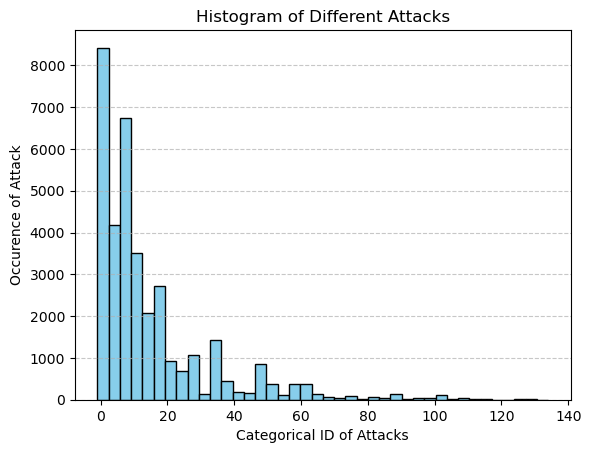

In [9]:
# The individual value in the above plot correspond to a specific attack, in the report we can have the entire mapping in the
# appendix. For some specific attacks which occur the most we can talk about those in the report specifically.

# Create a histogram
plt.hist(df1['Categorical_Schadeomschrijving'], bins=40, color='skyblue', edgecolor='black')

# Add labels and a title
plt.xlabel('Categorical ID of Attacks')
plt.ylabel('Occurence of Attack')
plt.title('Histogram of Different Attacks')

# Add a grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [10]:
# creating a sub dataframe containing the most frequent threat ids
# from the above histogram the following list of vulnerability ids is considered

freq_vul_id_list = list(range(0, 61))

df2 = df1[df1['Categorical_Schadeomschrijving'].isin(freq_vul_id_list)]
df2.head()

,Unnamed: 0,Titel,Advisory ID,NCSC ID,Versie,Uitgiftedatum,CVE-ID,NCSC inschaling,Kans,Schade,Schadeomschrijving,Toepassingen,Versies,Platformen,Beschrijving,Mogelijke oplossingen,Categorical_Schadeomschrijving
0,0,0-day SMB kwetsbaarheid in Windows Vista en Se...,32000,GOVCERT.NL-2009-261,1.01,2009-09-15T14:15:21+02:00,['CVE-2009-3103'],High/High,High,High,Uitvoeren van willekeurige code [Root/Administ...,[],[],"['Windows Server 2008', 'Windows Vista']",Er bevindt zich een 0-day kwetsbaarheid in de ...,Microsoft heeft nog geen update uit kunnen bre...,0
1,1,Kwetsbaarheden verholpen in Apple iOS en iPadOS,250093916,NCSC-2022-0776,1.00,2022-12-15T13:17:12+01:00,"['CVE-2022-32943', 'CVE-2022-40303', 'CVE-2022...",Medium/High,Medium,High,Lekken van gevoelige informatie [Gebruikersdat...,[],"['15.7.2', '16.1.2', '16.2']","['Apple iOS', 'Apple iPadOS']",Apple heeft kwetsbaarheden verholpen in iOS en...,Apple heeft updates uitgebracht om de kwetsbaa...,1
2,2,Kwetsbaarheid verholpen in Cacti,250094516,NCSC-2022-0759,1.01,2023-01-16T13:06:33+01:00,['CVE-2022-46169'],High/Medium,High,Medium,Lekken van gevoelige informatie [Systeemdata]\...,['Cacti'],['1.2.22'],[],Er zijn kwetsbaarheden verholpen in Cacti.\nDe...,Cacti heeft updates uitgebracht om de kwetsbaa...,2
3,3,IBM WebSphere MQ 7 Multiple Vulnerabilities,32001,GOVCERT.NL-2009-269,1.00,2009-09-15T16:39:38+02:00,['CVE-2009-3106'],Medium/High,Medium,High,Denial of service [Infrastructuur dienst],['IBM WebSphere MQ'],['7'],"['HP-UX', 'IBM AIX', 'IBM ZOS', 'Linux', 'Micr...",In IBM WebSphere MQ 7 is een aantal verschille...,IBM heeft een aantal security bulletins uitgeg...,3
4,4,Kwetsbaarheden verholpen in Apple macOS,250093926,NCSC-2022-0777,1.00,2022-12-15T13:17:27+01:00,"['CVE-2022-24836', 'CVE-2022-29181', 'CVE-2022...",Medium/High,Medium,High,Lekken van gevoelige informatie [Gebruikersdat...,[],"['11.7.2', '12.6.2', '13.1']",['Apple macOS'],Apple heeft kwetsbaarheden verholpen in macOS ...,Apple heeft updates beschikbaar gesteld voor m...,1


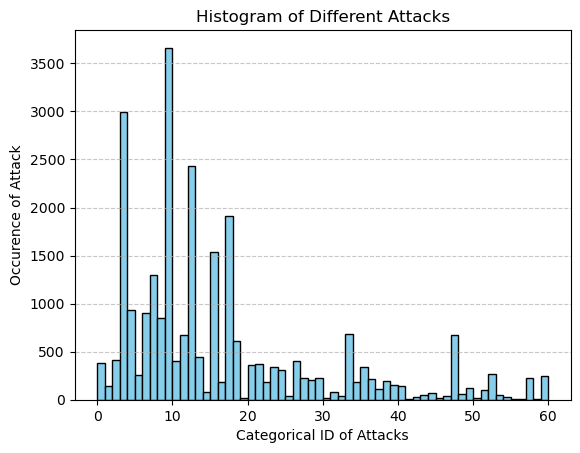

In [11]:
# Create a histogram
plt.hist(df2['Categorical_Schadeomschrijving'], bins=60, color='skyblue', edgecolor='black')

# Add labels and a title
plt.xlabel('Categorical ID of Attacks')
plt.ylabel('Occurence of Attack')
plt.title('Histogram of Different Attacks')

# Add a grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [12]:
#create a dict with the cumulative count of occurences and damage

def update_dict(temp_dict_var, cat_prob, cat_damg):
    if cat_prob:
        if cat_prob == "Medium":
            temp_dict_var["occ"][1] = temp_dict_var["occ"][1]+1    
        elif cat_prob == "High":
            temp_dict_var["occ"][3] = temp_dict_var["occ"][3]+1
    if cat_damg:
        if cat_damg == "Medium":
            temp_dict_var["dmg"][1] = temp_dict_var["dmg"][1]+1    
        elif cat_damg == "High":
            temp_dict_var["dmg"][3] = temp_dict_var["dmg"][3]+1
    return temp_dict_var


final_dict = {}

for id1, cat_prob, cat_damg in zip(df2["Categorical_Schadeomschrijving"],df2["Kans"],df2["Schade"]):
    if id1 not in final_dict:
        final_dict[id1] = {"occ":["Medium",0,"High",0],"dmg":["Medium",0,"High",0]}
        final_dict[id1] = update_dict(final_dict[id1], cat_prob, cat_damg)
    elif id1 in final_dict:
        final_dict[id1] = update_dict(final_dict[id1], cat_prob, cat_damg)

print(final_dict)


{0: {'occ': ['Medium', 298, 'High', 48], 'dmg': ['Medium', 2, 'High', 385]}, 1: {'occ': ['Medium', 131, 'High', 9], 'dmg': ['Medium', 1, 'High', 140]}, 2: {'occ': ['Medium', 321, 'High', 65], 'dmg': ['Medium', 409, 'High', 0]}, 3: {'occ': ['Medium', 2591, 'High', 234], 'dmg': ['Medium', 82, 'High', 2908]}, 4: {'occ': ['Medium', 707, 'High', 84], 'dmg': ['Medium', 920, 'High', 6]}, 5: {'occ': ['Medium', 208, 'High', 10], 'dmg': ['Medium', 252, 'High', 1]}, 6: {'occ': ['Medium', 690, 'High', 111], 'dmg': ['Medium', 3, 'High', 904]}, 7: {'occ': ['Medium', 1134, 'High', 95], 'dmg': ['Medium', 1261, 'High', 3]}, 8: {'occ': ['Medium', 794, 'High', 47], 'dmg': ['Medium', 68, 'High', 787]}, 9: {'occ': ['Medium', 2637, 'High', 881], 'dmg': ['Medium', 3626, 'High', 37]}, 10: {'occ': ['Medium', 276, 'High', 26], 'dmg': ['Medium', 394, 'High', 10]}, 11: {'occ': ['Medium', 611, 'High', 42], 'dmg': ['Medium', 7, 'High', 662]}, 12: {'occ': ['Medium', 1896, 'High', 288], 'dmg': ['Medium', 2432, 'High'

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27005 entries, 0 to 35682
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      27005 non-null  int64  
 1   Titel                           27005 non-null  object 
 2   Advisory ID                     27005 non-null  int64  
 3   NCSC ID                         27005 non-null  object 
 4   Versie                          27005 non-null  float64
 5   Uitgiftedatum                   27005 non-null  object 
 6   CVE-ID                          27005 non-null  object 
 7   NCSC inschaling                 27005 non-null  object 
 8   Kans                            27005 non-null  object 
 9   Schade                          27005 non-null  object 
 10  Schadeomschrijving              27005 non-null  object 
 11  Toepassingen                    27005 non-null  object 
 12  Versies                         

In [14]:
#processing the final dictionary to remove some clutter and make it easier to plot

max_occ = -1
max_dmg = -1

plot_dict = {}

for key, values in final_dict.items():
    occ_values = values['occ']
    max_occ = max(occ_values[1::2])  # Extract numerical values and find the maximum
    occ_cat_indx = occ_values.index(max_occ)
    dmg_values = values['dmg']
    max_dmg = max(dmg_values[1::2])  # Extract numerical values and find the maximum
    dmg_cat_indx = dmg_values.index(max_dmg)
    plot_dict[key] = [occ_values[occ_cat_indx-1],(occ_values[1] // 2) + occ_values[3],dmg_values[dmg_cat_indx-1], (dmg_values[1] // 2) + dmg_values[3]]

print(plot_dict)

{0: ['Medium', 197, 'High', 386], 1: ['Medium', 74, 'High', 140], 2: ['Medium', 225, 'Medium', 204], 3: ['Medium', 1529, 'High', 2949], 4: ['Medium', 437, 'Medium', 466], 5: ['Medium', 114, 'Medium', 127], 6: ['Medium', 456, 'High', 905], 7: ['Medium', 662, 'Medium', 633], 8: ['Medium', 444, 'High', 821], 9: ['Medium', 2199, 'Medium', 1850], 10: ['Medium', 164, 'Medium', 207], 11: ['Medium', 347, 'High', 665], 12: ['Medium', 1236, 'Medium', 1216], 13: ['Medium', 213, 'High', 444], 14: ['Medium', 52, 'High', 85], 15: ['Medium', 656, 'Medium', 772], 16: ['Medium', 104, 'High', 185], 17: ['Medium', 922, 'High', 1895], 18: ['Medium', 320, 'Medium', 303], 19: ['Medium', 10, 'High', 21], 20: ['Medium', 197, 'Medium', 182], 21: ['Medium', 199, 'High', 363], 22: ['Medium', 92, 'High', 178], 23: ['Medium', 143, 'High', 341], 24: ['Medium', 158, 'High', 310], 25: ['Medium', 27, 'Medium', 21], 26: ['Medium', 190, 'Medium', 203], 27: ['Medium', 98, 'High', 219], 28: ['Medium', 94, 'High', 205], 29

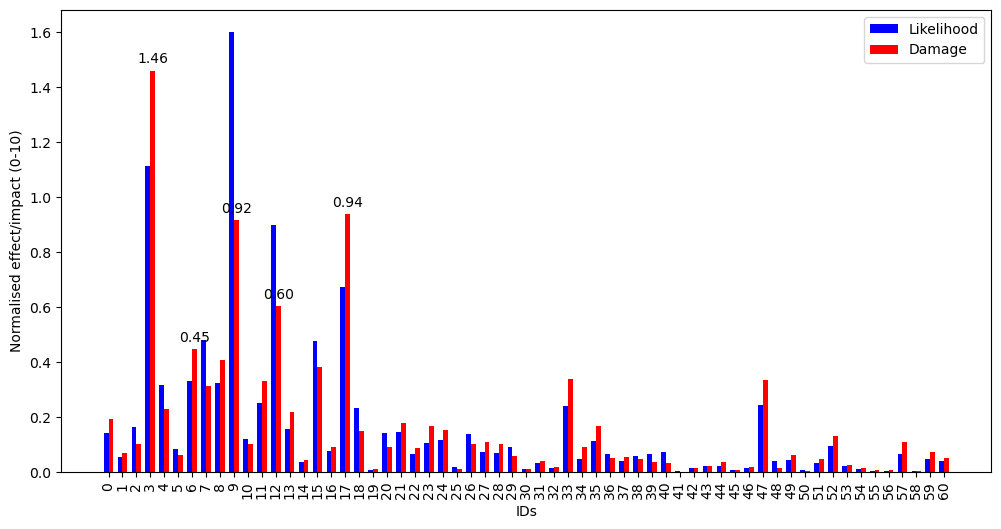

In [19]:
#plotting the cumulative likelihood and damage count along with displaying the top 5 damage values


# Organize the data into lists for 'likelihood' and 'damage'
likelihood_values = [10 * plot_dict[i][1] / sum([plot_dict[i][1] for i in plot_dict]) for i in plot_dict] 
damage_values = [10 * plot_dict[i][3] / sum([plot_dict[i][3] for i in plot_dict]) for i in plot_dict] 
ids = list(plot_dict.keys())

# Set the width of each bar and the number of data points
bar_width = 0.35
x = np.arange(len(ids))

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

# Create the bars for 'likelihood' and 'damage'
likelihood_bars = ax.bar(x - bar_width/2, likelihood_values, bar_width, label='Likelihood', color='blue')
damage_bars = ax.bar(x + bar_width/2, damage_values, bar_width, label='Damage', color='red')

# Add labels and a legend
ax.set_xlabel('IDs')
ax.set_ylabel('Normalised effect/impact (0-10)')
ax.set_xticks(x)
ax.set_xticklabels(ids,rotation=90)
ax.legend()

# Function to annotate the top N values with two decimal places
def annotate_top_values(rects, n):
    top_values = sorted(rects, key=lambda x: x.get_height(), reverse=True)[:n]
    for rect in top_values:
        value = round(rect.get_height(), 2)  # Round the value to two decimal places
        ax.annotate('{:.2f}'.format(value),  # Format the value with two decimal places
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# Annotate the top 10 values for 'Likelihood'
annotate_top_values(damage_bars, n=5)

# Show the plot
plt.show()
